<a href="https://colab.research.google.com/github/ajmoore12/WPA_Competition/blob/main/wpac_deep_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade google-cloud-bigquery-storage

In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB
Using device: cuda


In [ ]:
#Establishing connection to bigquery WPAC project
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery

project_id = 'wpac-449904'
# Create a storage client
client = bigquery.Client(project=project_id)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import files

In [ ]:
# uploaded = files.upload()

# successfile = list(uploaded.keys())[0]
# success_targets = pd.read_csv(successfile)
# success_targets.head()

## Sending table to BigQuery

In [ ]:
# import pandas_gbq


# dataset_table = "wpac_data.success_targets"  # Replace with dataset.table name

# # Load your CSV into a DataFrame
# csv_file_path = "success_targets.csv"  # Replace with your actual file path
# # df = pd.read_csv(csv_file_path)

# # Use `pandas_gbq.to_gbq` to upload DataFrame
# pandas_gbq.to_gbq(
#     success_targets,
#     destination_table=dataset_table,
#     project_id=project_id,
#     if_exists="replace"  # "fail", "replace", "append"
# )

## Querying Other Tables as Needed

In [ ]:
#Querying other_events table from BQ
query = """
SELECT * FROM `wpac-449904.wpac_data.final_job_merge`
"""

query2 = """
SELECT * FROM `wpac-449904.wpac_data.final_enrolling_merge`
"""
jobs_df = client.query(query).to_dataframe()
training_df = client.query(query2).to_dataframe()


In [ ]:
success_map = {
    'Unknown':'-1',
    'Unsuccessful User':'0',
    'Successful User':'1'
}

success_targets['Overall Success'] = success_targets['Overall Success'].replace(success_map).astype(int)
success_targets['Overall Success'].value_counts(dropna=False)

,count
Overall Success,
0,1159
1,598


In [ ]:
#Dropping Unknown records for modeling purposes
success_targets = success_targets[success_targets['Overall Success'] != -1]

In [ ]:
# Reorder columns so that 'WPA_id' and 'version' are the first two columns
column_order = ['WPA_id', 'cohort'] + [col for col in jobs_df.columns if col not in ['WPA_id', 'cohort']]
jobs_df = jobs_df[column_order]

column_order = ['WPA_id', 'cohort'] + [col for col in training_df.columns if col not in ['WPA_id', 'cohort']]
training_df = training_df[column_order]


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

jobs_df = jobs_df.fillna(-1)
training_df = training_df.fillna(-1)
print(jobs_df.isnull().sum())
print(training_df.isnull().sum())

WPA_id                                          0
cohort                                          0
children                                        0
concern_finances                                0
concern_health                                  0
concern_job                                     0
concern_job_search                              0
concern_social                                  0
contract_work                                   0
current_job_benefits_childcare                  0
current_job_benefits_education                  0
current_job_benefits_health                     0
current_job_benefits_none                       0
current_job_benefits_pto                        0
current_job_benefits_schedule                   0
current_job_benefits_training                   0
current_job_benefits_transportation             0
education                                       0
gender                                          0
household_adult_children                        0


In [ ]:
pd.set_option('display.max_rows', None)

dtype_columns = ['cohort', 'children', 'targetSalary', 'latestSalary']

for column in dtype_columns:
    jobs_df[column] = pd.to_numeric(jobs_df[column], errors='coerce')
    training_df[column] = pd.to_numeric(training_df[column], errors='coerce')
    jobs_df[column] = jobs_df[column].astype(int)
    training_df[column] = training_df[column].astype(int)


In [ ]:
# Identify datetime columns
datetime_cols = ['createdAt', 'updatedAt', 'lastLoggedInAt']  # Update list as needed

# Convert datetime to pandas datetime format (if not already done)
for col in datetime_cols:
    jobs_df[col] = pd.to_datetime(jobs_df[col], errors='coerce')
    training_df[col] = pd.to_datetime(training_df[col], errors='coerce')

# Extract meaningful features
for col in datetime_cols:
    jobs_df[f'{col}_year'] = jobs_df[col].dt.year
    jobs_df[f'{col}_month'] = jobs_df[col].dt.month
    jobs_df[f'{col}_day'] = jobs_df[col].dt.day
    jobs_df[f'{col}_weekday'] = jobs_df[col].dt.weekday  # Monday=0, Sunday=6
    jobs_df[f'{col}_hour'] = jobs_df[col].dt.hour  # Extract hour if applicable

    training_df[f'{col}_year'] = training_df[col].dt.year
    training_df[f'{col}_month'] = training_df[col].dt.month
    training_df[f'{col}_day'] = training_df[col].dt.day
    training_df[f'{col}_weekday'] = training_df[col].dt.weekday
    training_df[f'{col}_hour'] = training_df[col].dt.hour

# Drop original datetime columns
jobs_df.drop(columns=datetime_cols, inplace=True)
training_df.drop(columns=datetime_cols, inplace=True)


In [ ]:
success_df = success_targets.merge(jobs_df, on='WPA_id', how='inner')  #jobs_df has all columns
success_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 140 columns):
 #    Column                                        Dtype  
---   ------                                        -----  
 0    WPA_id                                        object 
 1    Overall Success                               int64  
 2    cohort                                        int64  
 3    children                                      int64  
 4    concern_finances                              Int64  
 5    concern_health                                Int64  
 6    concern_job                                   Int64  
 7    concern_job_search                            Int64  
 8    concern_social                                Int64  
 9    contract_work                                 Int64  
 10   current_job_benefits_childcare                Int64  
 11   current_job_benefits_education                Int64  
 12   current_job_benefits_health                   

In [ ]:
success_drop_cols = [
      'target_new_job',
      'skillup_training',
      'target_training_enrolled',
      'training_field',
      'training_support_services',
      'employ_Unemployed',
      'race_y',  #Duplicate
]

success_df.drop(columns=success_drop_cols, inplace=True)
success_df.head()

,WPA_id,Overall Success,cohort,children,concern_finances,concern_health,concern_job,concern_job_search,concern_social,contract_work,current_job_benefits_childcare,current_job_benefits_education,current_job_benefits_health,current_job_benefits_none,current_job_benefits_pto,current_job_benefits_schedule,current_job_benefits_training,current_job_benefits_transportation,education,gender,household_adult_children,household_decline,household_none,household_other,household_other_relatives,household_parents,household_siblings,household_spouse,household_young_children,income_covered_expenses,job_confidence,new_job_looking,primary_work_schedule,public_benefits_childcare,public_benefits_decline,public_benefits_disability,public_benefits_eitc,public_benefits_medicare,public_benefits_none,public_benefits_pell,public_benefits_snap,public_benefits_tanf,public_benefits_ui,public_benefits_wioa,race_x,skillup_entry_reason_current_industry_skills,skillup_entry_reason_lost_job,skillup_entry_reason_new_industry_skills,skillup_helpful_awareness_career,skillup_helpful_awareness_training,skillup_helpful_confidence_job,training_plan_to_enroll,years_experience,new_industry_Business,new_industry_Healthcare,new_industry_Skilled Trades,new_industry_Technology,new_industry_Transportation & Logistics,main_reason_advancement,main_reason_benefits,main_reason_better_hours,main_reason_commute,main_reason_environment,main_reason_higher_pay,job_challenge_callback,job_challenge_education,job_challenge_experience,job_challenge_interest,job_challenge_interviewing,job_challenge_networking,job_challenge_training,payment_Contractor,payment_annual,payment_hourly,expenses_Decreased,expenses_Increased,expenses_Stayed the same,industry_Business,industry_Healthcare,industry_Skilled Trades,industry_Supply Chain & Logistics,industry_Technology,industry_Transportation & Logistics,income,previous_job_income,skillup_recommend,rural_type,myPathCompleted,preferredRegionGroup,workExperienceGroup,latestSalary,latestSalaryType,targetSalary,completed_work_styles,retention,completed_career_milestone,completed_jobs_milestone,completed_training_milestone,gender_3,activeMilestone_careers,activeMilestone_job,activeMilestone_training,educationAndWorkExperience_11-14 years,educationAndWorkExperience_15+ years,educationAndWorkExperience_2-4 years,educationAndWorkExperience_5-10 years,educationAndWorkExperience_< 2 years,educationAndWorkExperience_Missing,eventName_clicked on a resource,eventName_edited status,eventName_saved catalog item,eventName_viewed a catalog item,collectionType_careers,collectionType_jobs,collectionType_resources,collectionType_training,eventType_my_path,num_of_touches,createdAt_year,createdAt_month,createdAt_day,createdAt_weekday,createdAt_hour,updatedAt_year,updatedAt_month,updatedAt_day,updatedAt_weekday,updatedAt_hour,lastLoggedInAt_year,lastLoggedInAt_month,lastLoggedInAt_day,lastLoggedInAt_weekday,lastLoggedInAt_hour
0,WPA_10013,0,1,-1,1,1,2,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,3,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000.0,0.0,10.0,0,1,1,0,-1,-1,-1,0,1,0,0,0,-1,0,0,1,0,0,0,0,0,0,0,0,2,0,1,0,0,1,2.0,2.0,2022,12,8,3,17,2024,12,5,3,16,2023,6,7,2,11
1,WPA_100511,0,7,2,4,1,4,2,4,1,0,0,1,0,1,0,1,0,2,1,0,0,0,0,0,0,0,0,1,0,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,4,2,2,1,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,35000.0,35000.0,7.0,1,1,0,1,-1,-1,-1,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,6,6,12,0,0,0,12.0,12.0,2024,5,3,4,6,2024,10,4,4,23,2024,10,4,4,23
2,WPA_10073,1,1,-1,4,4,4,4,4,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,4,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,25000.0,45000.0,6.5,-1,0,0,0,-1,-1,-1,0,0,-1,-1,-1,-1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,2022,12,9,4,11,2023,12,11,0,23,2022,12,9,4,11
3,WPA_101102,0,7,0,2,1,4,3,2,0,0,0,1,0,1,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,3,2,1

In [ ]:
print(success_df['WPA_id'].nunique())
print(len(success_df))

1757
1757


In [ ]:
training_cols_drop = [
    'skillup_training',
    'training_field',
    'training_plan_to_enroll',
    'training_support_services',
    'race_y',
    'completed_training_milestone',
    'activeMilestone_training'
]

training_df.drop(columns=training_cols_drop, inplace=True)

In [ ]:
print(jobs_df.info(verbose=True))
print(training_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6296 entries, 0 to 6295
Data columns (total 139 columns):
 #    Column                                        Dtype  
---   ------                                        -----  
 0    WPA_id                                        object 
 1    cohort                                        int64  
 2    children                                      int64  
 3    concern_finances                              Int64  
 4    concern_health                                Int64  
 5    concern_job                                   Int64  
 6    concern_job_search                            Int64  
 7    concern_social                                Int64  
 8    contract_work                                 Int64  
 9    current_job_benefits_childcare                Int64  
 10   current_job_benefits_education                Int64  
 11   current_job_benefits_health                   Int64  
 12   current_job_benefits_none                     

In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify all numeric columns (excluding target & WPA_id)
numeric_cols_jobs = [col for col in jobs_df.columns if col not in ['WPA_id', 'target_new_job']]
numeric_cols_training = [col for col in training_df.columns if col not in ['WPA_id', 'target_training_enrolled']]
numeric_cols_success = [col for col in success_df.columns if col not in ['WPA_id', 'Overall Success']]

# Initialize scalers
scaler_jobs = StandardScaler()
scaler_training = StandardScaler()
scaler_success = StandardScaler()

# Apply StandardScaler
jobs_df[numeric_cols_jobs] = scaler_jobs.fit_transform(jobs_df[numeric_cols_jobs])
training_df[numeric_cols_training] = scaler_training.fit_transform(training_df[numeric_cols_training])
success_df[numeric_cols_success] = scaler_success.fit_transform(success_df[numeric_cols_success])


In [ ]:
success_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 133 columns):
 #    Column                                        Dtype  
---   ------                                        -----  
 0    WPA_id                                        object 
 1    Overall Success                               int64  
 2    cohort                                        float64
 3    children                                      float64
 4    concern_finances                              float64
 5    concern_health                                float64
 6    concern_job                                   float64
 7    concern_job_search                            float64
 8    concern_social                                float64
 9    contract_work                                 float64
 10   current_job_benefits_childcare                float64
 11   current_job_benefits_education                float64
 12   current_job_benefits_health                   

In [ ]:
from sklearn.model_selection import train_test_split

# Jobs dataset
X_jobs = jobs_df.drop(columns=['target_new_job', 'WPA_id'])
y_jobs = jobs_df['target_new_job']
X_train_jobs, X_test_jobs, y_train_jobs, y_test_jobs = train_test_split(X_jobs, y_jobs, test_size=0.2, random_state=42)
X_train_jobs, X_val_jobs, y_train_jobs, y_val_jobs = train_test_split(X_train_jobs, y_train_jobs, test_size=0.1, random_state=42)

# Training dataset
X_training = training_df.drop(columns=['target_training_enrolled', 'WPA_id'])
y_training = training_df['target_training_enrolled']
X_train_training, X_test_training, y_train_training, y_test_training = train_test_split(X_training, y_training, test_size=0.2, random_state=42)
X_train_training, X_val_training, y_train_training, y_val_training = train_test_split(X_train_training, y_train_training, test_size=0.1, random_state=42)

# Success dataset
X_success = success_df.drop(columns=['Overall Success', 'WPA_id'])
X_success = X_success.astype('float32')
y_success = success_df['Overall Success']
X_train_success, X_test_success, y_train_success, y_test_success = train_test_split(X_success, y_success, test_size=0.2, random_state=42)
X_train_success, X_val_success, y_train_success, y_val_success = train_test_split(X_train_success, y_train_success, test_size=0.1, random_state=42)

In [ ]:
# !pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define model architecture
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Build and train model for jobs
model_jobs = build_model(X_train_jobs.shape[1])
history_jobs = model_jobs.fit(
    X_train_jobs, y_train_jobs,
    validation_data=(X_val_jobs, y_val_jobs),
    epochs=50, batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Build and train model for training
model_training = build_model(X_train_training.shape[1])
history_training = model_training.fit(
    X_train_training, y_train_training,
    validation_data=(X_val_training, y_val_training),
    epochs=50, batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

#Build and train model for success
model_success = build_model(X_train_success.shape[1])
history_success = model_success.fit(
    X_train_success, y_train_success,
    validation_data=(X_val_success, y_val_success),
    epochs=50, batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5820 - loss: 0.7764 - val_accuracy: 0.7718 - val_loss: 0.4894
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7474 - loss: 0.5104 - val_accuracy: 0.7956 - val_loss: 0.4562
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7850 - loss: 0.4508 - val_accuracy: 0.8016 - val_loss: 0.4360
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8074 - loss: 0.4205 - val_accuracy: 0.7937 - val_loss: 0.4223
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8154 - loss: 0.3936 - val_accuracy: 0.7917 - val_loss: 0.4198
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8340 - loss: 0.3507 - val_accuracy: 0.7956 - val_loss: 0.4323
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8469 - loss: 0.3309 - val_accuracy: 0.8115 - val_loss: 0.4248
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - loss: 0.3188 - val_accuracy: 0.8036 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5966 - loss: 0.7374 - val_accuracy: 0.7516 - val_loss: 0.5426
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7191 - loss: 0.5814 - val_accuracy: 0.7529 - val_loss: 0.5374
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7320 - loss: 0.5508 - val_accuracy: 0.7529 - val_loss: 0.5370
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7374 - loss: 0.5325 - val_accuracy: 0.7632 - val_loss: 0.5172
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7614 - loss: 0.5030 - val_accuracy: 0.7426 - val_loss: 0.5384
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7713 - loss: 0.4951 - val_accuracy: 0.7465 - val_loss: 0.5355
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7744 - loss: 0.4773 - val_accuracy: 0.7413 - val_loss: 0.5524
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7853 - loss: 0.4604 - val_accuracy: 0.7490 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.5834 - loss: 0.8204 - val_accuracy: 0.7376 - val_loss: 0.5407
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7544 - loss: 0.5219 - val_accuracy: 0.7376 - val_loss: 0.5411
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7917 - loss: 0.4640 - val_accuracy: 0.7376 - val_loss: 0.5304
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8169 - loss: 0.3904 - val_accuracy: 0.7305 - val_loss: 0.5841
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8366 - loss: 0.3644 - val_accuracy: 0.7943 - val_loss: 0.5519
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8616 - loss: 0.3131 - val_accuracy: 0.7660 - val_loss: 0.5999
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8806 - loss: 0.2961 - val_accuracy: 0.7730 - val_loss: 0.5861
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8711 - loss: 0.2959 - val_accuracy: 0.7589 - val_loss: 0.6889


In [ ]:
# Evaluate model for jobs
test_loss_jobs, test_acc_jobs = model_jobs.evaluate(X_test_jobs, y_test_jobs)
print(f"Jobs Model - Test Accuracy: {test_acc_jobs:.4f}")

# Evaluate model for training
test_loss_training, test_acc_training = model_training.evaluate(X_test_training, y_test_training)
print(f"Training Model - Test Accuracy: {test_acc_training:.4f}")

# Evaluate model for training
test_loss_success, test_acc_success = model_success.evaluate(X_test_success, y_test_success)
print(f"Training Model - Test Accuracy: {test_acc_success:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7644 - loss: 0.4666
Jobs Model - Test Accuracy: 0.7889
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7388 - loss: 0.5600
Training Model - Test Accuracy: 0.7360
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7949 - loss: 0.4436 
Training Model - Test Accuracy: 0.7841


## Now We Perform Hyperparameter Tuning to Improve Performance

In [ ]:
from keras.optimizers import Adam

# Define a function to train the model with different hyperparameters
def train_model(lr, batch_size, dropout_rate):
    model = keras.Sequential([
        # layers.Dense(256, activation='relu', input_shape=(X_train_jobs.shape[1],)),  #jobs_df training
        # layers.Dense(256, activation='relu', input_shape=(X_train_training.shape[1],)),  #training_df
        layers.Dense(256, activation='relu', input_shape=(X_train_success.shape[1],)),  #success_df
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(
        # X_train_jobs, y_train_jobs,  #jobs_df
        # X_train_training, y_train_training,  #training_df
        X_train_success, y_train_success,  #success_df
        # validation_data=(X_val_jobs, y_val_jobs),  #jobs_df
        # validation_data=(X_val_training, y_val_training),  #training_df
        validation_data=(X_val_success, y_val_success),  #success_df
        epochs=50,
        batch_size=batch_size,
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    # test_loss, test_acc = model.evaluate(X_test_jobs, y_test_jobs)  #jobs_df
    # test_loss, test_acc = model.evaluate(X_test_training, y_test_training)  #training_df
    test_loss, test_acc = model.evaluate(X_test_success, y_test_success)  #success_df
    print(f"Test Accuracy with LR={lr}, Batch={batch_size}, Dropout={dropout_rate}: {test_acc:.4f}")
    return test_acc

# Run tuning with different values - jobs_df dptimized parameters: lr=.002, batch_size=32, dropout_rate=.4 with accuracy .8770
# training_df optimized parameters: lr=.001, batch_size=64, dropout_rate=.2
# success_df optimized parameters: lr=.001, batch_size=64, dropout_rate=.2
# for lr in [0.0005, 0.001, 0.002]:
#     for batch_size in [32, 64, 128]:
#         for dropout_rate in [0.2, 0.3, 0.4]:
#             train_model(lr, batch_size, dropout_rate)


## Final Training

In [ ]:
# Define the optimized model with the best hyperparameters
def build_optimized_model(input_shape, lr_opt, dropout_opt, lasso):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lasso),input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_opt),

        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lasso)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_opt),

        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lasso)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_opt),

        layers.Dense(1, activation='sigmoid')
    ])

    # Use the optimal learning rate
    optimizer = keras.optimizers.Adam(learning_rate=lr_opt)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Train Jobs Model
final_model_jobs = build_optimized_model(X_train_jobs.shape[1], lr_opt=0.003, dropout_opt=0.35, lasso=.005)
history_final_jobs = final_model_jobs.fit(
    X_train_jobs, y_train_jobs,
    validation_data=(X_val_jobs, y_val_jobs),
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# # Train Training Enrollment Model
# final_model_training = build_optimized_model(X_train_training.shape[1], lr_opt=0.0025, dropout_opt=0.7, lasso=.0015)
# history_final_training = final_model_training.fit(
#     X_train_training, y_train_training,
#     validation_data=(X_val_training, y_val_training),
#     epochs=100,
#     batch_size=64,
#     callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
# )

# # Train Success Model
# final_model_success = build_optimized_model(X_train_success.shape[1], lr_opt=0.0025, dropout_opt=0.8, lasso=0.01)
# history_final_success = final_model_success.fit(
#     X_train_success, y_train_success,
#     validation_data=(X_val_success, y_val_success),
#     epochs=100,
#     batch_size=32,
#     callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
# )


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6362 - loss: 2.6881 - val_accuracy: 0.7937 - val_loss: 1.8004
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7810 - loss: 1.6376 - val_accuracy: 0.7778 - val_loss: 1.1683
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7938 - loss: 1.0566 - val_accuracy: 0.7778 - val_loss: 0.8601
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8036 - loss: 0.7805 - val_accuracy: 0.7897 - val_loss: 0.7175
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8019 - loss: 0.6883 - val_accuracy: 0.7996 - val_loss: 0.6572
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8003 - loss: 0.6487 - val_accuracy: 0.7996 - val_loss: 0.6276
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.6091 - val_accuracy: 0.7996 - val_loss: 0.6157
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8080 - loss: 0.6082 - val_accuracy: 0.801

## Feature Importance

PermutationExplainer explainer: 1261it [01:06, 18.43it/s]


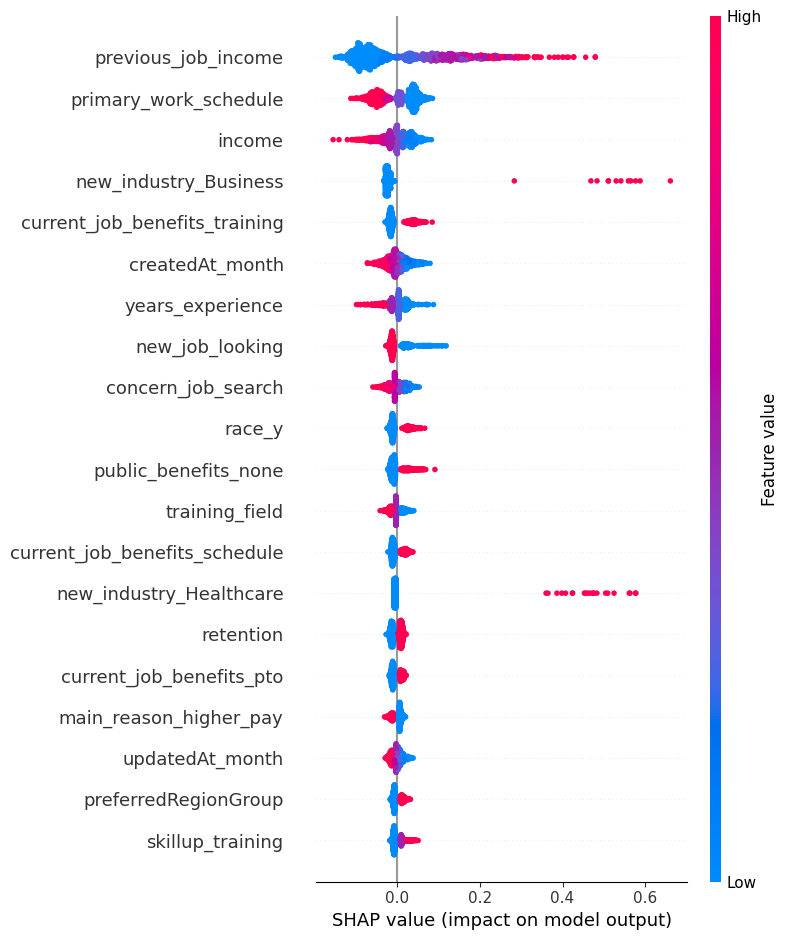

In [ ]:
import shap

# Explain the jobs model
explainer_jobs = shap.Explainer(final_model_jobs, X_test_jobs)
shap_values_jobs = explainer_jobs(X_test_jobs)

# Plot feature importance
shap.summary_plot(shap_values_jobs, X_test_jobs)

PermutationExplainer explainer: 1944it [01:24, 20.16it/s]


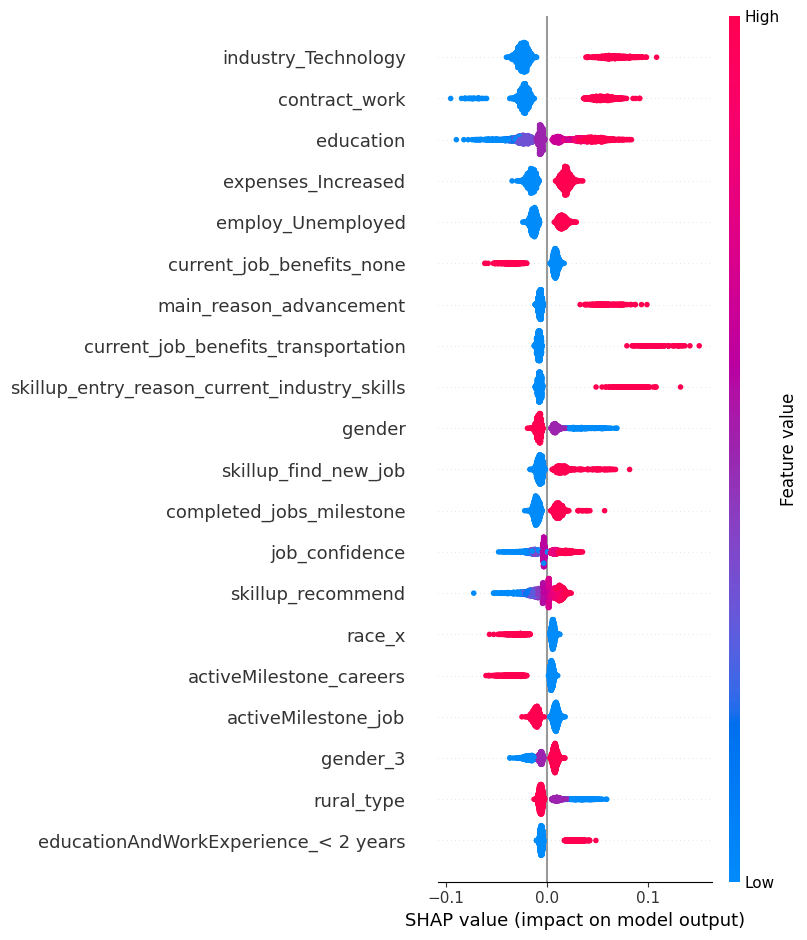

In [ ]:
# Explain the jobs model
explainer_training = shap.Explainer(final_model_training, X_test_training)
shap_values_training = explainer_training(X_test_training)

# Plot feature importance
shap.summary_plot(shap_values_training, X_test_training)

PermutationExplainer explainer: 353it [00:24,  9.00it/s]


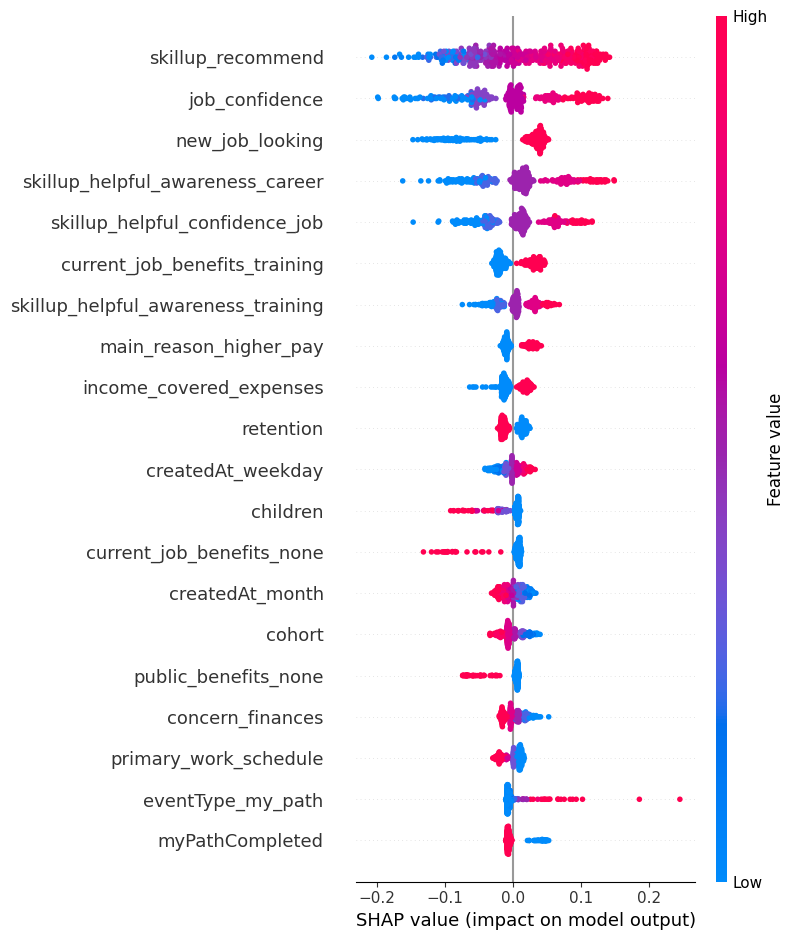

In [ ]:
# Explain the success model
explainer_success = shap.Explainer(final_model_success, X_test_success)
shap_values_success = explainer_success(X_test_success)

# Plot feature importance
shap.summary_plot(shap_values_success, X_test_success)

## Checking for Overfitting

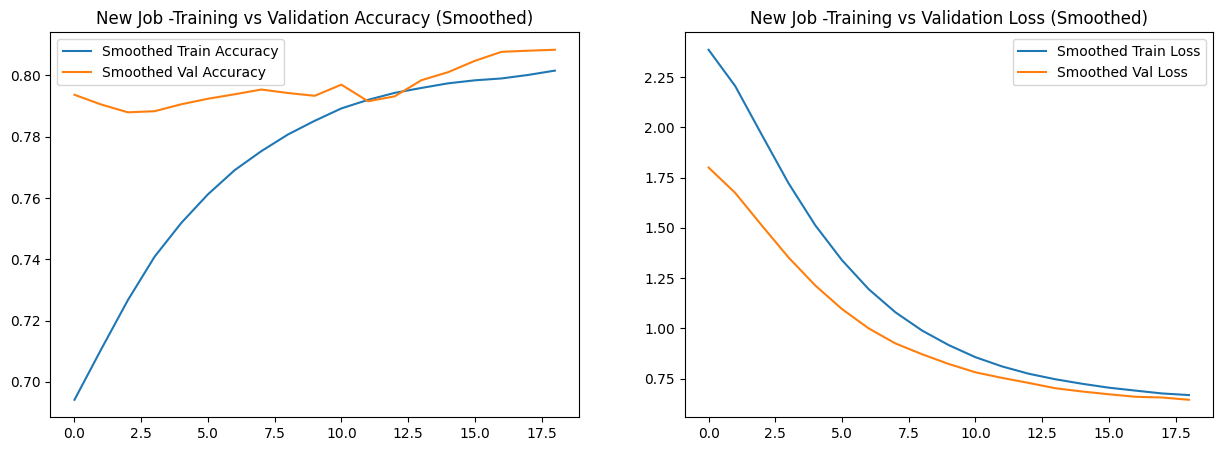

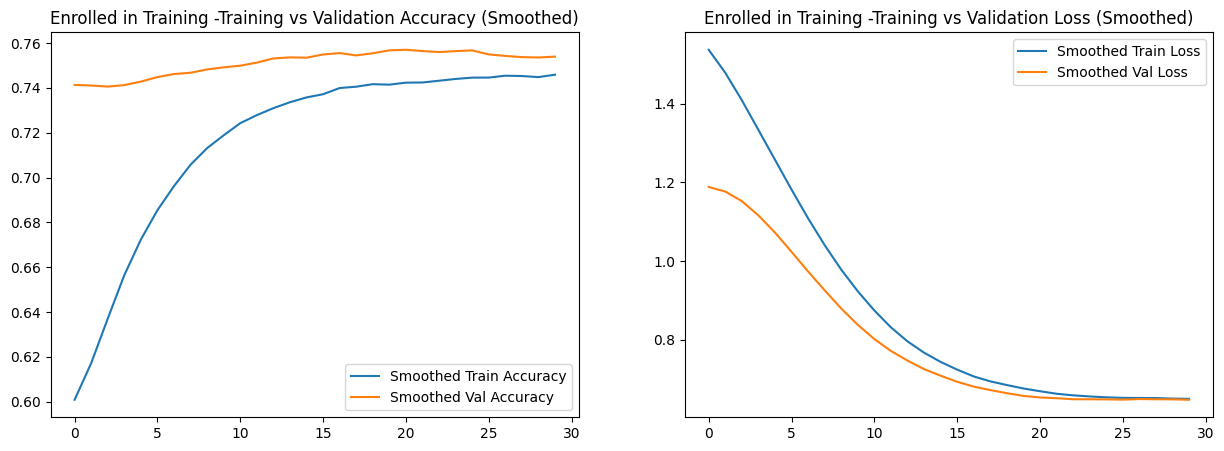

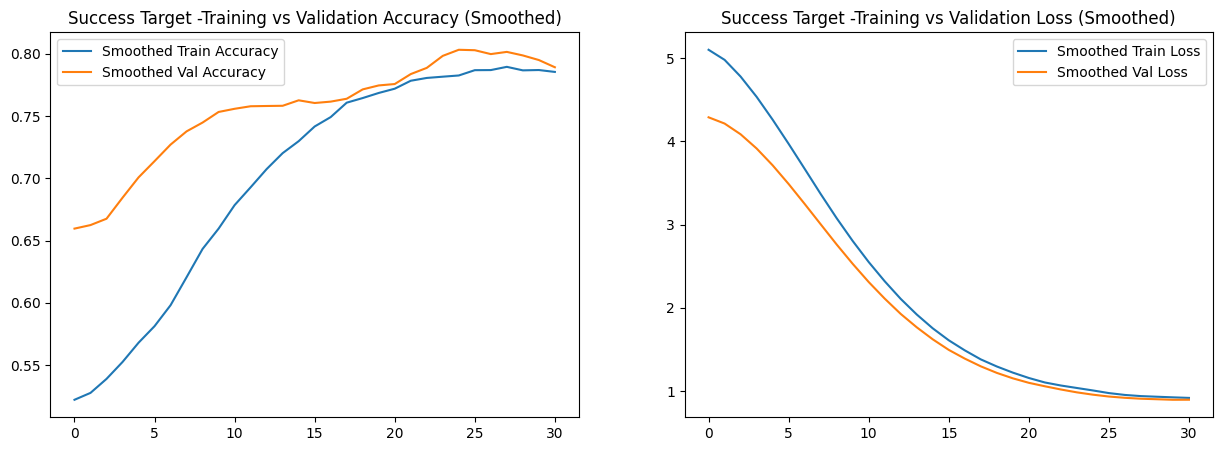

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
  def smooth_curve(points, factor=0.8):
      smoothed_points = []
      for point in points:
          if smoothed_points:
              smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
          else:
              smoothed_points.append(point)
      return smoothed_points

  plt.figure(figsize=(15, 5))

  # Plot smoothed accuracy
  plt.subplot(1, 2, 1)
  plt.plot(smooth_curve(history.history['accuracy']), label='Smoothed Train Accuracy')
  plt.plot(smooth_curve(history.history['val_accuracy']), label='Smoothed Val Accuracy')
  plt.title(title + 'Training vs Validation Accuracy (Smoothed)')
  plt.legend()

  # Plot smoothed loss
  plt.subplot(1, 2, 2)
  plt.plot(smooth_curve(history.history['loss']), label='Smoothed Train Loss')
  plt.plot(smooth_curve(history.history['val_loss']), label='Smoothed Val Loss')
  plt.title(title + 'Training vs Validation Loss (Smoothed)')
  plt.legend()

  plt.show()

# Plot for Jobs Model
plot_training_history(history_final_jobs, "New Job -")

# # Plot for Training Model
plot_training_history(history_final_training, "Enrolled in Training -")

# Plot for Training Model
plot_training_history(history_final_success, "Success Target -")


In [ ]:
final_model_jobs.save('final_model_jobs_v4.keras')
final_model_training.save('final_model_training_v2.keras')
final_model_success.save('final_model_success_v2.keras')

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


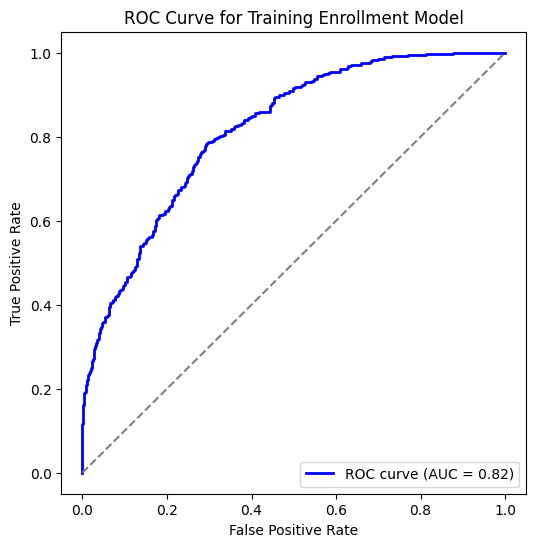

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_probs = final_model_jobs.predict(X_test_jobs)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_jobs, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Enrollment Model')
plt.legend(loc='lower right')
plt.show()


# End of Deep Learninig

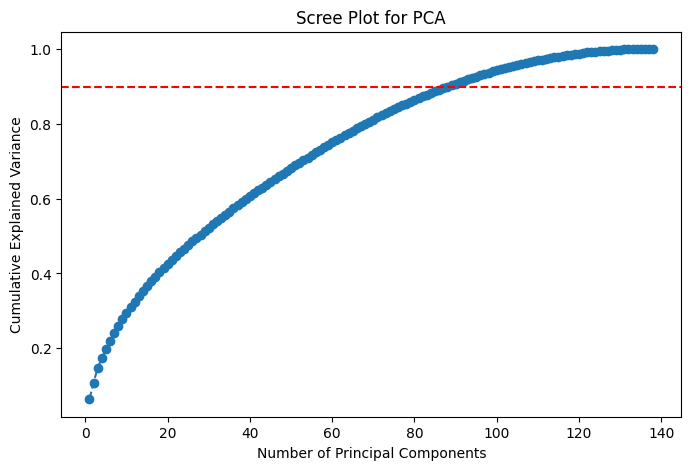

Optimal number of components: 89


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns before PCA
df_pca_ready = jobs_df.drop(columns=['WPA_id'])

# Select numeric columns
numeric_cols = df_pca_ready.select_dtypes(include=[int, float]).columns
df_numeric = df_pca_ready[numeric_cols]

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA without setting n_components
pca = PCA()
pca.fit(df_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot for PCA")
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% variance threshold
plt.show()

# Find the number of components that explain at least 90% of variance
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Optimal number of components: {optimal_components}")

In [ ]:
# Use the optimal number of components
pca = PCA(n_components=optimal_components)
df_pca = pca.fit_transform(df_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(optimal_components)])
print(df_pca.head())

# Check total variance explained by 66 components
total_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total variance explained by 66 components: {total_variance:.2%}")

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.537459  0.102943 -0.372958 -0.259496  0.083210  1.222409  1.477880   
1  1.890426 -3.771445 -3.947566 -3.435307  0.930032  2.966122 -1.262232   
2  3.605245 -2.639820  0.142956 -0.536946  0.723244 -2.736743  1.088262   
3 -3.379087  2.476010  2.138847  1.077332 -1.428561  0.791944 -0.884993   
4  3.567419 -1.941530 -0.043088  0.093308 -1.862472 -3.725675  2.875225   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  1.415612  0.611249  1.276788  0.684950  0.245341 -0.829645  1.443032   
1 -0.604405 -2.139878  1.120311  0.882993  1.018159 -0.051843 -1.022724   
2 -0.293657 -0.343683  2.808366  0.545568  1.075483 -0.204052 -0.490762   
3 -1.195048  1.021803  1.115814 -0.168129  1.641632 -1.571557  0.071852   
4  0.921754 -0.767572  0.847440 -0.740735  0.735895 -1.565689 -0.520234   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0  0.022619  0.406250  

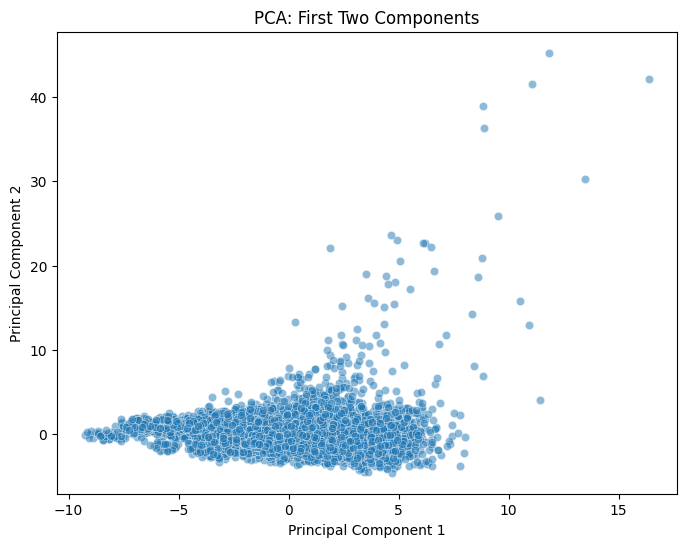

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Components")
plt.show()


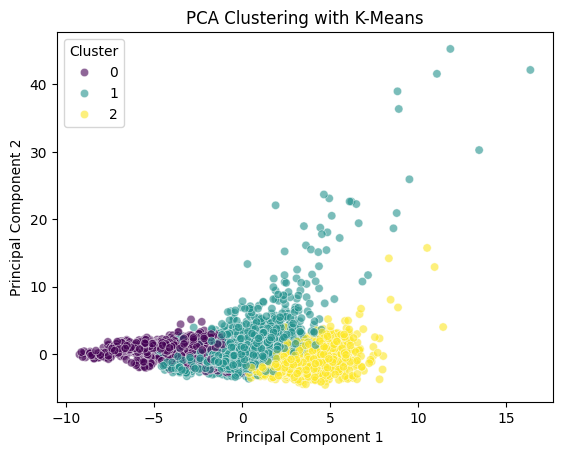

In [ ]:
from sklearn.cluster import KMeans

# Choose the number of clusters (try different values)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_pca)

# Add cluster labels to the PCA DataFrame
df_pca['Cluster'] = clusters

# Visualize clusters
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster'], palette='viridis', alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Clustering with K-Means")
plt.show()


In [ ]:
# Get PCA loadings
loadings = pd.DataFrame(pca.components_, columns=df_numeric.columns, index=[f'PC{i+1}' for i in range(89)])

# Display top 10 most important features for the first principal component
print(loadings.T.abs().nlargest(10, 'PC1'))


                               PC1       PC2       PC3       PC4       PC5  \
cohort                    0.258759  0.136366  0.117296  0.029821  0.071202   
createdAt_year            0.248854  0.122379  0.118227  0.079874  0.006353   
lastLoggedInAt_year       0.223298  0.018208  0.084221  0.161286  0.004509   
updatedAt_year            0.211374  0.010286  0.074986  0.149517  0.031124   
myPathCompleted           0.190525  0.061084  0.109760  0.086293  0.102312   
children                  0.176584  0.101341  0.017781  0.190549  0.173589   
gender_3                  0.164773  0.056324  0.101973  0.003612  0.072703   
concern_finances          0.158846  0.000900  0.146635  0.106946  0.214964   
household_spouse          0.154390  0.079157  0.013365  0.100475  0.114976   
household_young_children  0.152269  0.073302  0.000423  0.121798  0.154412   

                               PC6       PC7       PC8       PC9      PC10  \
cohort                    0.051444  0.061479  0.036563  0.05456

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Example: Predict new_job
X = df_pca  # PCA-transformed features
y = jobs_df['target_new_job']  # Target variable

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2%}")


Model Accuracy: 83.73%
